Precision Score for PGS.OL: 0.41964285714285715
            Target  Predictions
Date                           
2017-09-05       1          0.0
2017-09-06       0          0.0
2017-09-07       0          0.0
2017-09-08       0          0.0
2017-09-11       0          0.0
...            ...          ...
2023-11-01       1          0.0
2023-11-02       0          0.0
2023-11-03       0          0.0
2023-11-06       0          0.0
2023-11-07       0          0.0

[1552 rows x 2 columns]


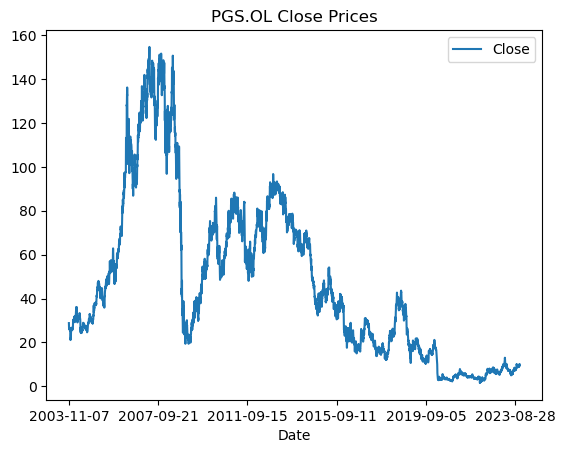

In [11]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def analyze_ticker(ticker_symbol):
    x = yf.Ticker(ticker_symbol)
    x = x.history(period="max")

    x.index = pd.to_datetime(x.index)
    x.index = x.index.strftime('%Y-%m-%d')

    x.plot.line(y="Close", use_index=True)
    plt.title(f"{ticker_symbol} Close Prices")

    del x["Dividends"]
    del x["Stock Splits"]

    x["Tomorrow"] = x["Close"].shift(-1)

    x["Target"] = (x["Tomorrow"] > x["Close"]).astype(int)

    x = x.loc["1990-01-01":].copy()

    model = RandomForestClassifier(n_estimators=250, min_samples_split=50, random_state=1)

    horizons = [2, 5, 60, 250, 1000]
    new_predictors = []

    for horizon in horizons:
        rolling_averages = x.rolling(horizon).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        x[ratio_column] = x["Close"] / rolling_averages["Close"]

        trend_column = f"Trend_{horizon}"
        x[trend_column] = x.shift(1).rolling(horizon).sum()["Target"]

        new_predictors += [ratio_column, trend_column]

    x = x.dropna(subset=x.columns[x.columns != "Tomorrow"])

    model = RandomForestClassifier(n_estimators=250, min_samples_split=50, random_state=1)

    predictions = backtest(x, model, new_predictors)

    precision = precision_score(predictions["Target"], predictions["Predictions"])

    return x, precision, predictions

# Example of how to use the function:
ticker_symbol = "PGS.OL"
data, precision, predictions = analyze_ticker(ticker_symbol)


# Show the precision score
print(f"Precision Score for {ticker_symbol}: {precision}")
# Display the predictions
print(predictions)
# Show the graph
plt.show()
